In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import random as rd

In [81]:
data = pd.read_csv("mammographic_masses.data",header=None)
### Signification de chaque caracteristique, dans l'ordre ###
# BI RADS
# Age de la patiente
# Forme de la masse, non ordinal
# Frontière de la masse, non ordinal 
# Densité, ordinal
# Bénigne (0) ou maline (1)

Nombre de cas bénins : 516
Nombre de cas malins : 445


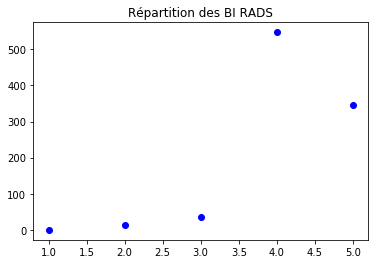

In [36]:
# Répartition des issues
print("Nombre de cas bénins : " + str(sum(data[5] == 0)))
print("Nombre de cas malins : " + str(sum(data[5] == 1)))

# Evaluations avec BI RADS
plt.figure()
plt.title("Répartition des BI RADS")
plt.plot(range(1,6), [sum(data[0] == str(i)) for i in range(1,6)], 'bo')

In [34]:
# Simulation de choix de medecins par lancer de piece par la classification binaire

# Classification binaire en utilisant raykar

# Autres classifications a venir sur meme modele
# Sous condition de trouver base de donnees adapte ( ou utiliser celle la comme il faut)

In [74]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def p_i(w, x):
    # w est un vecteur, x est une matrice
    w = w.reshape(-1)
    return sigmoid(w.dot(x))

def a_i(alpha, y):
    # Renvoie le vecteur des a_i
    # On passe par le logarithme pour calculer le produit
    log_alpha_1 = np.log(alpha)
    log_alpha_2 = np.log(1 - alpha)
    log_sum = y.dot(log_alpha_1) + (1 - y).dot(log_alpha_2)
    return np.exp(log_sum)

def b_i(beta, y):
    # Renvoie le vecteur des b_i
    # On passe par le logarithme pour calculer le produit
    log_alpha_1 = np.log(beta)
    log_alpha_2 = np.log(1 - beta)
    log_sum = y.dot(log_alpha_1) + (1 - y).dot(log_alpha_2)
    return np.exp(log_sum)

def alpha_j(mu, y):
    return mu.dot(y) / np.sum(mu)

def beta_j(mu, y):
    return (1 - mu).dot(1 - y) / np.sum(1 - mu)

def mu_i(data,w,alpha,y,mu):
    a = a_i(alpha,y)
    p = p_i(w,x)
    b = b_i(mu,y)
    numerateur = a*p
    denominateur = numerateur + b*(1-p)
    return numerateur/denominateur

In [71]:
def norme(w):
    return(np.sqrt(w.dot(w)))

def grad(data, mu, w):
    p = p_i(w, data)
    return (mu - p).dot(data)

def hess(data, w):
    p = p_i(w,data)
    diag = np.diag(p * (1 - p))
    hess_mat = diag.dot(data.T)
    return diag.dot((data.T).dot(data))

def gradient_descent(grad_vect, hess_mat, mu, winit, max_iter = 1000, stop = 1e-4):
    pas = 1
    w = winit
    w_plus = 0
    while (i<max_iter) & (norme(w_plus-w)>stop):
        w_plus = w - pas * np.linalg.pinv(hess(data,w)) * grad(data,mu,w)
        pas = 1/np.sqrt(i)
        w = w_plus
    return w

In [79]:
def EM_algorithm(data, labels, winit, nb_iter = 50):
    mu = np.mean(labels, axis = 1) #initilisation de mu
    w = winit #initialisation de w
    for ite in range(nb_iter):
        #E step
        mu = mu_i(data,w,alpha,y,mu)#met à jour mu
        #M step
        alpha = alpha_j(mu, labels) #met à jour alpha
        beta = beta_j(mu, labels) #met à jour beta
        w = gradient_descent(grad(data,mu,w),hess(data,w),mu,w) #met à jour w

In [142]:
#Pour chaque patient, chaque medecin décide si la tumeur est maligne ou bénine.
#Ce choix est modélisé comme étant un tirage uniforme sur [0,1]
#Le "niveau" du medecin determine ensuite la taille de la zone dans laquelle
#il a raison
def choix_medecin(level_medecin,data):
    nb_medecin = len(level_medecin)
    nb_patient = len(data)
    Mat = np.array([[(data[i])==(rd.random() < level_medecin[j]) for j in range(nb_medecin) ]for i in range(nb_patient)])
    return Mat

In [146]:
w = np.array([0.5, 0.2])
x = np.array([[1,0],[1,2]])

don = np.array([i%2 for i in range(10)])
lev = np.array([i*1.0/5 for i in range(5)])
M = choix_medecin(lev,don)
M[:,1]==don

array([False,  True, False, False,  True, False, False, False,  True, False], dtype=bool)